# Using PySindy to learn 2D Quadrotor Dynamics

## Setup Dataset for Bayesian PySindy by Simulating Model

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pysindy as ps
from sbr import SBR


# Plant model for the 2D Quadrotor
def plant_model(t, current_state, T1, T2):
    """ Function to simulate non-linear SS model for 2D Quadrotor
    :param t: current time step in simulation
    :param current_state: [x, x_dot, z, z_dot, theta, theta_dot]
    :param T1: control input thrust 1
    :param T2: control input thrust 2
    :return: [x_dot, x_2dot, z_dot, z_2dot, theta_dot, theta_2dot]
    """
    # Define constants
    m, g, l = 0.027, 9.8, 0.0397
    Iyy = 1.4e-5

    # Define states
    x, x_dot, z, z_dot, theta, theta_dot = current_state

    # Define dynamics equations
    # x_dot = x_dot
    x_2dot = np.sin(theta) * (T1 + T2) / m
    # z_dot = z_dot
    z_2dot = np.cos(theta) * (T1 + T2) / m - g
    # theta_dot = theta_dot
    theta_2dot = l * (T2 - T1) / Iyy / np.sqrt(2)
    return [x_dot, x_2dot, z_dot, z_2dot, theta_dot, theta_2dot]


def simulate_dynamics(T1, T2, t_span, initial_states, n_samples):
    sol = solve_ivp(plant_model, t_span, initial_states, args=(T1, T2), t_eval=np.linspace(t_span[0], t_span[1], n_samples))
    return sol.t, sol.y.T  


# Generate data from model
initial_states = [0, 0, 0, 0, np.pi/4, 0] # Initial states [x, x_dot, z, z_dot, theta, theta_dot]
t_span = (0, 10) # s
T1, T2 = 1.001, 1.0 # Constant thrust inputs
n_samples = 500

# Get the simulated time and state data
t, states = simulate_dynamics(T1, T2, t_span, initial_states, n_samples)

# Add Gaussian white noise to the data
gwn = np.random.normal(0, 2.0, size=states.shape)
noisy_states = states + gwn

In [59]:
print(gwn)

[[-0.5043957   3.67042599 -3.12159273  1.01730368 -3.60484104 -2.51987987]
 [-0.51635251 -1.09387088 -2.94577748  0.81226346  1.43882699  1.47816672]
 [ 0.55843548 -0.5137398  -3.11407504  3.98707682 -1.10347692  4.97600166]
 ...
 [ 2.82275208 -1.93265431  4.37955856 -1.61031685 -3.23685102 -1.52665089]
 [ 1.76332081 -1.13726421 -0.79636774 -4.64675587 -1.56644842 -0.69457023]
 [ 1.89564253 -2.48729796 -2.92253383 -2.36573841  1.04398916  1.20671571]]


## Plot Simulated Data

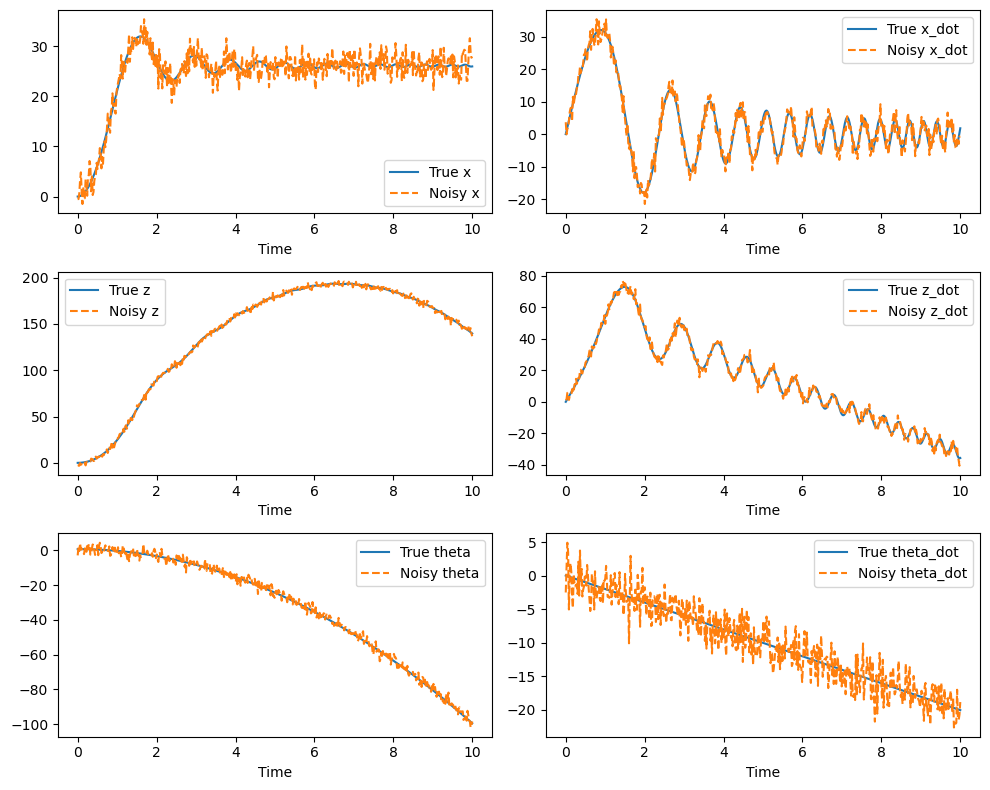

In [64]:
fig, ax = plt.subplots(3, 2, figsize=(10, 8))
labels = ['x', 'x_dot', 'z', 'z_dot', 'theta', 'theta_dot']

for i in range(6):
    ax[i // 2, i % 2].plot(t, states[:, i], label=f"True {labels[i]}")
    ax[i // 2, i % 2].plot(t, noisy_states[:, i], '--', label=f"Noisy {labels[i]}")
    ax[i // 2, i % 2].set_xlabel('Time')
    ax[i // 2, i % 2].legend()

plt.tight_layout()
plt.show()

## Setup Bayesian PySindy Model

In [61]:
# Setup the SINDy model with Bayesian inference
num_warmup = 100
num_chains = 2
sampling_seed = 42
optim = SBR(num_warmup=num_warmup, 
            num_samples=500,
            mcmc_kwargs={"seed": sampling_seed, "num_chains": num_chains})

# Use a Fourier feature library due to trig functions in dynamics
n_frequencies = 1 
feature_library = ps.FourierLibrary(n_frequencies=n_frequencies)

# Initialize the SINDy model
model = ps.SINDy(optimizer=optim, 
                 feature_library=feature_library, 
                 feature_names=['x', 'x_dot', 'z', 'z_dot', 'theta', 'theta_dot'] # states of system
                 )

# Fit the model to the data
model.fit(noisy_states, t=t)

/Users/lancepharand/Desktop/LOCAL_URA_F24/GP_model_vs_BLR_model/sbr.py:171: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
sample: 100%|██████████| 600/600 [00:00<00:00, 695.83it/s, 63 steps of size 7.63e-02. acc. prob=0.57] 


SINDy(differentiation_method=FiniteDifference(),
      feature_library=<pysindy.feature_library.fourier_library.FourierLibrary object at 0x34ed3f380>,
      feature_names=['x', 'x_dot', 'z', 'z_dot', 'theta', 'theta_dot'],
      optimizer=SBR(mcmc_kwargs={'num_chains': 2, 'seed': 42}, num_samples=500,
                    num_warmup=100))

## Print the State Equations and Obtain Predictions

In [62]:
# Print the learned equations
model.print()

(x)' = -5.690 sin(1 x) + 3.566 cos(1 x) + 2.295 sin(1 x_dot) + -0.378 cos(1 x_dot) + 0.488 sin(1 z) + -2.464 cos(1 z) + 1.391 sin(1 z_dot) + 0.010 cos(1 z_dot) + 2.424 sin(1 theta) + 1.717 cos(1 theta) + -8.250 sin(1 theta_dot) + 11.372 cos(1 theta_dot)
(x_dot)' = 1.630 sin(1 x) + -1.661 cos(1 x) + -6.956 sin(1 x_dot) + 2.849 cos(1 x_dot) + -0.173 sin(1 z) + -0.029 cos(1 z) + -0.303 sin(1 z_dot) + 2.843 cos(1 z_dot) + 1.324 sin(1 theta) + -0.391 cos(1 theta) + -0.091 sin(1 theta_dot) + 1.142 cos(1 theta_dot)
(z)' = -1.650 sin(1 x) + 10.541 cos(1 x) + -0.969 sin(1 x_dot) + 6.225 cos(1 x_dot) + 1.532 sin(1 z) + 5.138 cos(1 z) + -0.460 sin(1 z_dot) + -0.366 cos(1 z_dot) + -4.593 sin(1 theta) + -1.488 cos(1 theta) + -0.383 sin(1 theta_dot) + -4.930 cos(1 theta_dot)
(z_dot)' = 1.650 sin(1 x) + -0.466 cos(1 x) + 0.412 sin(1 x_dot) + 0.207 cos(1 x_dot) + 6.581 sin(1 z) + -9.876 cos(1 z) + 14.196 sin(1 z_dot) + -7.148 cos(1 z_dot) + 6.919 sin(1 theta) + 7.958 cos(1 theta) + 2.078 sin(1 theta_d

## Plot the Predicted Derivatives

In [66]:
# Test the model
t_test = np.linspace(0, 10, 500) # s
initial_state_test = [0, 0, 0, 0, np.pi/4, 0] # Initial states

# Simulate using the learned equations from the model
simulated_states = model.simulate(initial_state_test, t_test)

In [70]:
print(simulated_states)

[[  0.           0.           0.           0.           0.78539816
    0.        ]
 [  0.29564198   0.11266144   0.24269437  -0.10266869   0.71595033
   -0.12396796]
 [  0.57621343   0.21819487   0.46427369  -0.18440821   0.60974879
   -0.23255806]
 ...
 [  6.91093373   0.39498153  71.43756887  -1.75954215 -76.39774011
    9.58042823]
 [  6.74566342   0.32992402  71.82629744  -1.85649591 -76.74943683
    9.90787064]
 [  6.66636157   0.26764486  72.21128504  -2.01208402 -77.04112446
   10.2209656 ]]


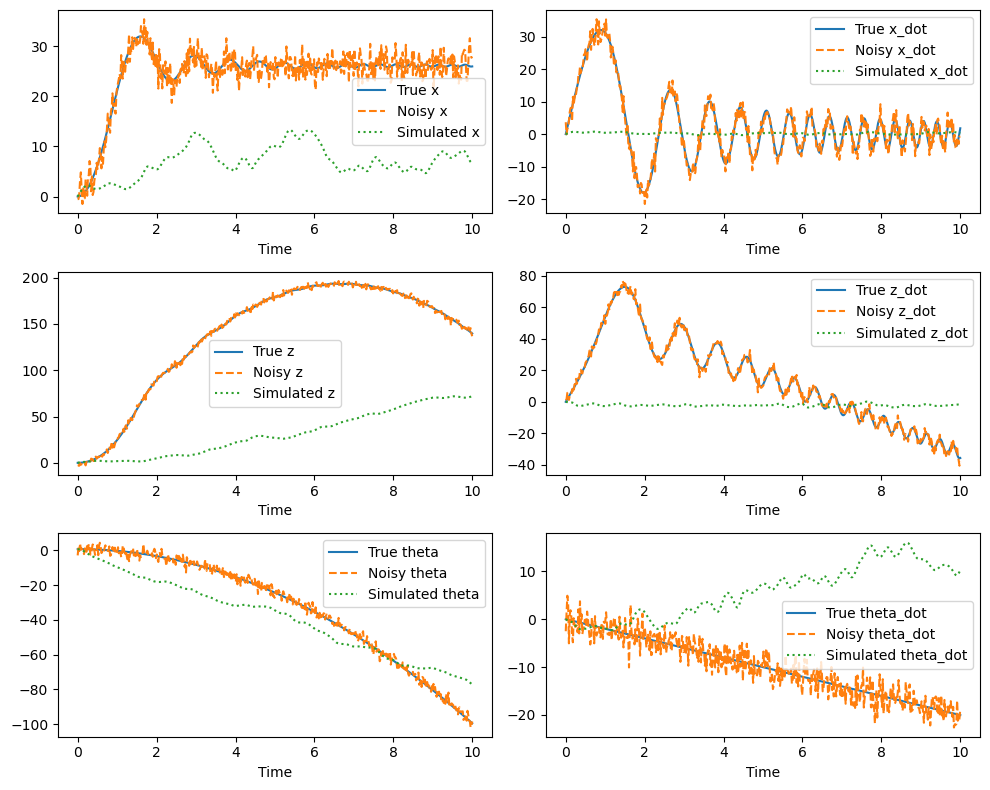

In [67]:
# Plot the results: Compare true states, noisy states, and simulated states
fig, ax = plt.subplots(3, 2, figsize=(10, 8))
labels = ['x', 'x_dot', 'z', 'z_dot', 'theta', 'theta_dot']

for i in range(6):
    ax[i // 2, i % 2].plot(t, states[:, i], label=f"True {labels[i]}")
    ax[i // 2, i % 2].plot(t, noisy_states[:, i], '--', label=f"Noisy {labels[i]}")
    ax[i // 2, i % 2].plot(t_test, simulated_states[:, i], ':', label=f"Simulated {labels[i]}")
    ax[i // 2, i % 2].set_xlabel('Time')
    ax[i // 2, i % 2].legend()

plt.tight_layout()
plt.show()